<a href="https://colab.research.google.com/github/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/blob/main/PredictionComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utility Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import os
import collections
import json
from google.colab import files

In [ ]:
!wget https://github.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/raw/main/Dataset/P2_measurements.zip
!unzip P2_measurements.zip -d P2_measurements

In [3]:
cwd = "/content/P2_measurements"

# Set the following flag to True to consider the whole Hysteresis Curve, including
# the first Magnetization curve.
include_first_magnetization = True

# The scaler is used to rescale the dataset values between -1 and 1
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

# Creating a dictionary containing all the measurements divided by frequency
dataset = {}
columns = ["t", "B", "H", "-H"] # t: timestamp, B: Magnetic Flux Density, H: Magnetic Field 

for file in os.listdir(cwd):
    temp_data = pd.read_csv(os.path.join(cwd, file),sep=';', header=None, names=columns)
    # Normalizing the Dataset 
    temp_data_norm = pd.DataFrame(scaler.fit_transform(temp_data[['H', 'B']]), columns=['H', 'B']) 
    if include_first_magnetization:
        dataset[file] = temp_data_norm
    else:
        # Select only the second half of the curve
        dataset[file] = temp_data_norm[int(len(temp_data)/2):].reset_index(drop=True)

dataset = collections.OrderedDict(sorted(dataset.items(), key=lambda t: t[1].shape, reverse=True))

In [4]:
seq_len = 20
subsample = True
subsample_len = 200 

val_dataset = collections.OrderedDict()

if subsample:
    for freq in dataset:
        if freq != 'P2_1kHz.CSV':
            if freq != 'P2_20Hz.CSV': 
                val_dataset[freq] = dataset[freq].iloc[np.arange(int((len(dataset[freq])/subsample_len) / 2), len(dataset[freq]), int(len(dataset[freq])/subsample_len))]
            else:
                val_dataset[freq] = dataset[freq].iloc[np.arange(0, len(dataset[freq]), int(len(dataset[freq])/subsample_len))]
else:
    for freq in dataset:
        if freq == 'P2_20Hz.CSV':
            val_dataset[freq] = dataset[freq]

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def plot_prediction(prediction, ground_truth, input_signal, frequency):

    MSE = mean_squared_error(y_true=ground_truth, y_pred=prediction)
    MAE = mean_absolute_error(y_true=ground_truth, y_pred=prediction)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(frequency)

    ax1.set_title('Prediction')
    ax1.scatter(input_signal, prediction)
    ax1.grid(True)
    ax1.text(x=-1, y=0.9, s='MSE:' + str(round(MSE, 6)), fontsize=12)
    ax1.text(x=-1, y=0.75, s='MAE:' + str(round(MAE, 6)), fontsize=12)

    ax2.set_title('Ground Truth')
    ax2.scatter(input_signal, ground_truth, c='orange')
    ax2.grid(True)

# Predictions Comparisons:
The training has been performed over the Dataset with the exclusion of the median frequency (input at 20 Hz), each input frequency subsampled to 200 samples, including the first magnetization curve. The sequence length, for comparison purposes is fixed to 20. 

## Model with repeated batches

dRNN with 256 units with tanh in the output layer: 
*  Stateful Training
*  Subsampling the Dataset to **200** samples per each frequency
*  Training Batches containing 10 sequences of 20 elements, one for each input frequency (**except** for **20 Hz**)
*  The **Validation Set** contains the 20 Hz curve and a different sampling of all the other frequencies also present in the Training Set, except for the 1kHz curve.
*  Each curve is represented once in its entirety, then the second period of each curve is repeated to fill 100 batches. The total number of repetitions is 10
*  50 epochs, 100 batches, $5000$ gradient updates.

In [6]:
# Read prediction file    
with open('/content/dRNN_256_units_seq_len_20_stateful_True_first_magnetization_True_subsampling_True_repeated_10_epochs_50.h5_predictions.txt', 'r') as file:
     model_predictions = json.load(file)

### Validation Set Predictions

Already seen frequencies **Interpolation**:

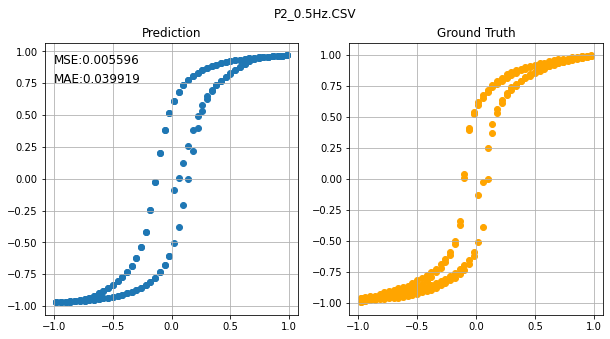

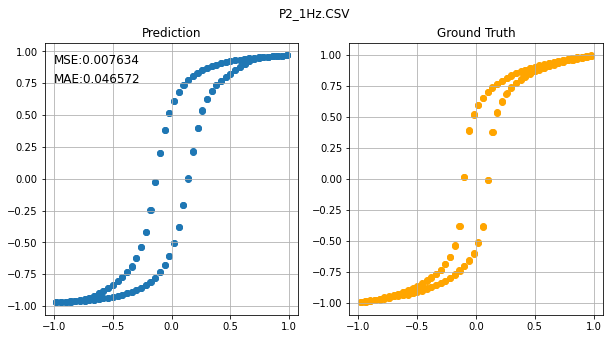

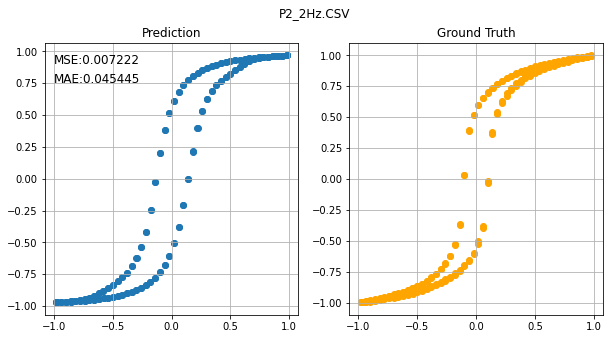

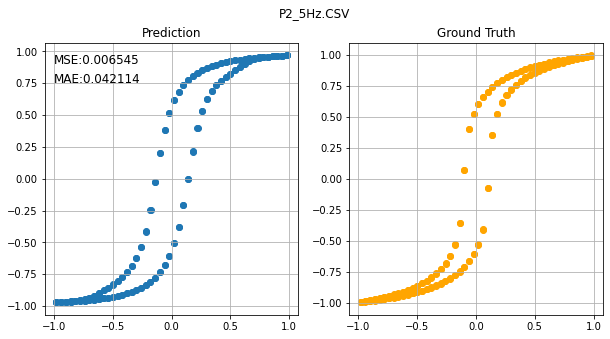

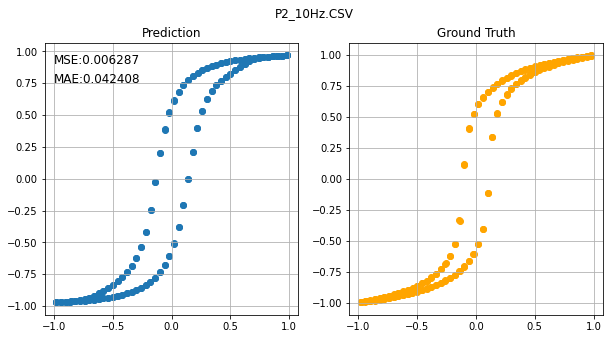

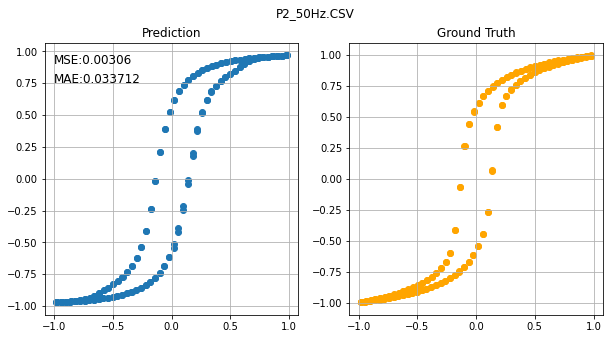

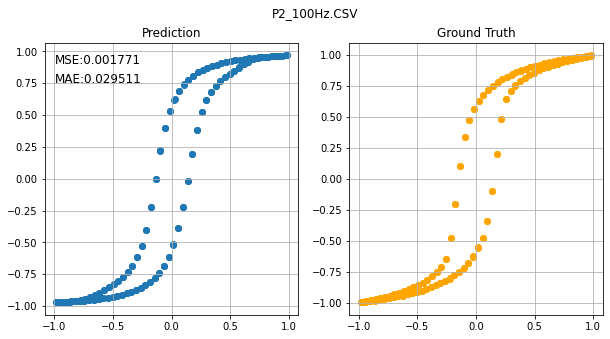

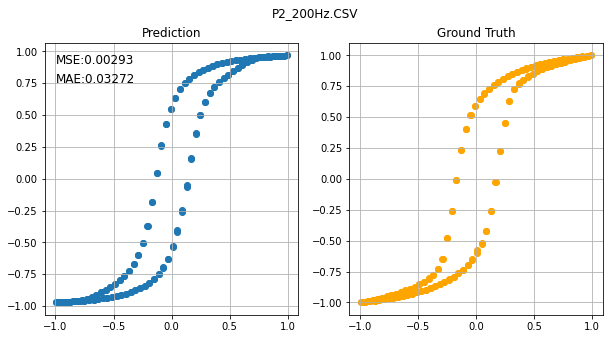

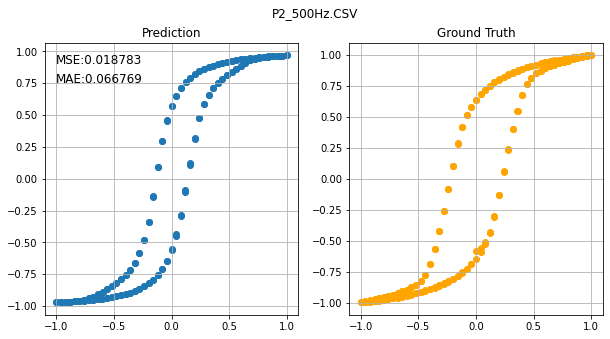

In [8]:
# Testing the model on the validation data, excluded the 20 Hz signal
y_pred = []

for freq in val_dataset:
    if freq != 'P2_20Hz.CSV':
        x_signal = np.array(val_dataset[freq][['H']])
    
        # Divide the signal in batches
        x = x_signal.reshape(-1, seq_len)

        # Reshape batch predictions into a single array
        y_pred = np.array(model_predictions[freq]).reshape(-1, 1)
        y_true = val_dataset[freq]['B']
    
        plot_prediction(y_pred, y_true, x_signal, freq)

New frequency **Extrapolation**:

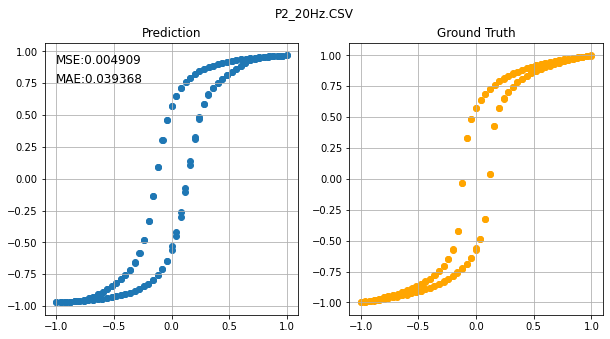

In [9]:
# Testing the model on the 20 Hz signal in the Validation Data
y_pred = []

freq = 'P2_20Hz.CSV'
        
x_signal = np.array(val_dataset[freq][['H']])
    
# Divide the signal in batches
x = x_signal.reshape(-1, seq_len)

# Reshape batch predictions into a single array
y_pred = np.array(model_predictions[freq]).reshape(-1, 1)
y_true = val_dataset[freq]['B']
    
plot_prediction(y_pred, y_true, x_signal, freq)

## Model with no repetition

dRNN with 256 units with tanh in the output layer: 
*  Stateful Training
*  Subsampling the Dataset to 200 samples per each frequency
*  Training Batches containing 10 sequences of 20 elements, one for each input frequency (**except for 20 Hz**)
*  The Validation Set contains the 20 Hz curve and a different sampling of all the other frequencies also present in the Training Set, except for the 1kHz curve.
*  Each curve is represented once in its entirety.
*  500 epochs, 10 batches, $5000$ gradient updates.

In [10]:
# Read prediction file    
with open('/content/dRNN_256_units_seq_len_20_stateful_True_first_magnetization_True_subsampling_True_repeated_1_epochs_500.h5_predictions.txt', 'r') as file:
     model_predictions = json.load(file)

### Validation Set Predictions

Already seen frequencies **Interpolation**:

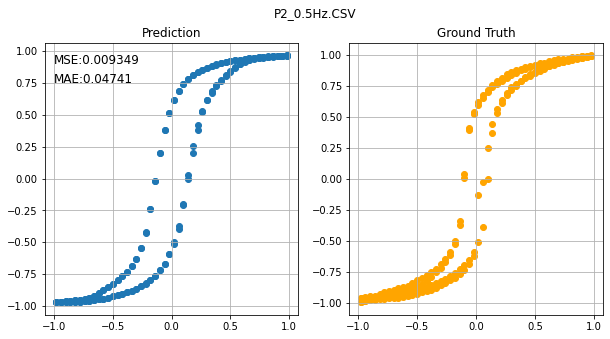

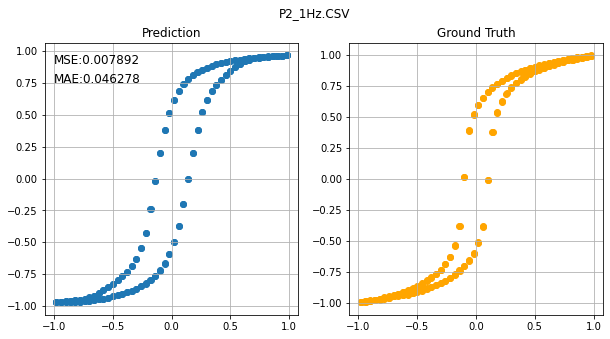

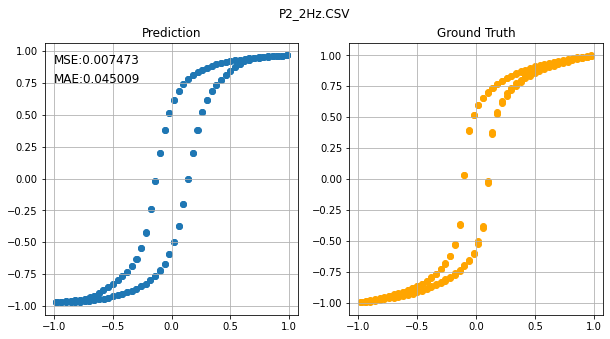

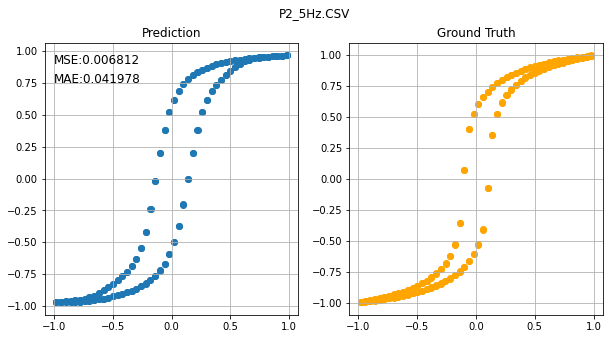

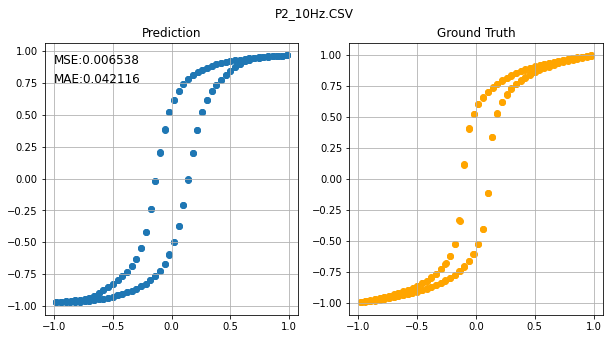

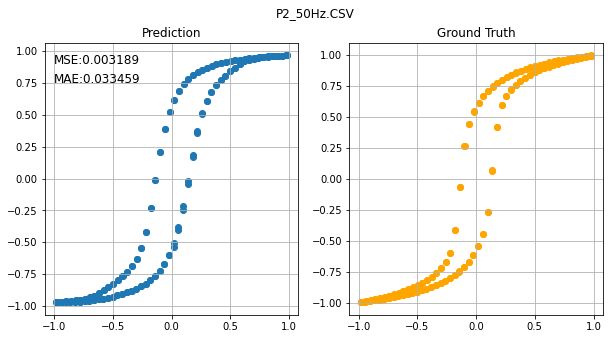

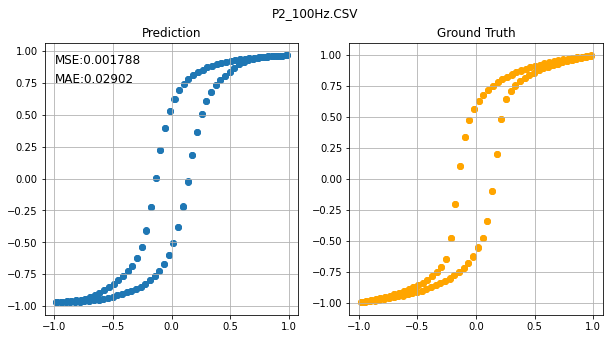

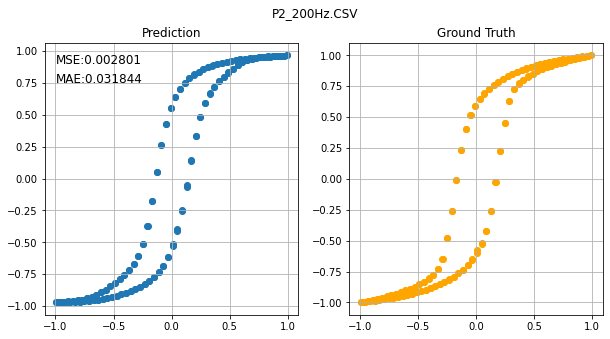

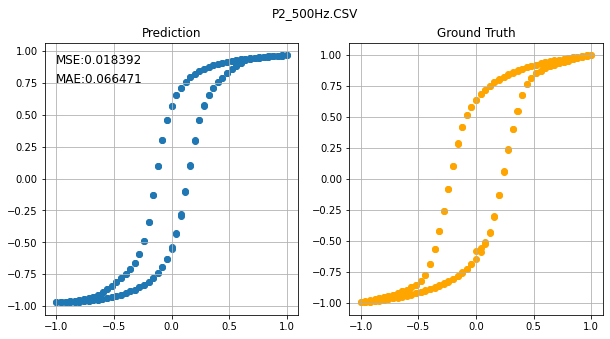

In [12]:
# Testing the model on the validation data, excluded the 20 Hz signal
y_pred = []

for freq in val_dataset:
    if freq != 'P2_20Hz.CSV':
        x_signal = np.array(val_dataset[freq][['H']])
    
        # Divide the signal in batches
        x = x_signal.reshape(-1, seq_len)

        # Reshape batch predictions into a single array
        y_pred = np.array(model_predictions[freq]).reshape(-1, 1)
        y_true = val_dataset[freq]['B']
    
        plot_prediction(y_pred, y_true, x_signal, freq)

New frequency **Extrapolation**:

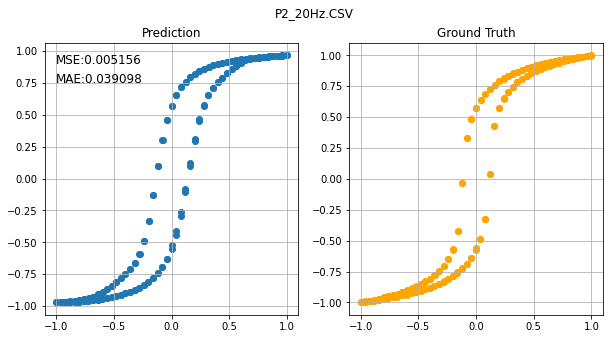

In [13]:
# Testing the model on the 20 Hz signal in the Validation Data
y_pred = []

freq = 'P2_20Hz.CSV'
        
x_signal = np.array(val_dataset[freq][['H']])
    
# Divide the signal in batches
x = x_signal.reshape(-1, seq_len)

# Reshape batch predictions into a single array
y_pred = np.array(model_predictions[freq]).reshape(-1, 1)
y_true = val_dataset[freq]['B']
    
plot_prediction(y_pred, y_true, x_signal, freq)